In [1]:
import sys
import os
import yaml
import os
import glob

sys.path.append('..')

In [2]:
ckpt = '2408/cifar10-ddpm-l1/9'
training_rootdir = '/group/jug/ashesh/training/diffsplit/'




ckpt = ckpt.strip('/').strip(' ')
ckpt

'2408/cifar10-ddpm-l1/9'

In [3]:
def load_config(ckpt):
    config_path = os.path.join(training_rootdir,ckpt,'wandb/latest-run/files/config.yaml')

    with open(config_path) as stream:
        try:
            opt = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    
    keys = ["name","phase","gpu_ids","path","datasets","model","train","distributed"]
    return {k: opt[k]['value'] for k in keys}

In [4]:
opt = load_config(ckpt)

if 'patch_size' not in opt['datasets']:
    opt['datasets']['patch_size']  = opt['datasets']['train']['patch_size']

if 'max_qval' not in opt['datasets']:
    opt['datasets']['max_qval']  = 0.98

if 'uncorrelated_channels' not in opt['datasets']['train']:
    opt['datasets']['train']['uncorrelated_channels']  = False



In [5]:
import torch
import data as Data
import model as Model
from data.split_dataset import SplitDataset, DataLocation
from split import get_datasets
import os


# data
train_set, val_set = get_datasets(opt)

# model
diffusion = Model.create_model(opt)
diffusion.set_new_noise_schedule(opt['model']['beta_schedule'][opt['phase']], schedule_phase=opt['phase'])

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.14 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


/group/jug/ashesh/data/cifar-10-python/train/data_batch_3
/group/jug/ashesh/data/cifar-10-python/train/data_batch_4
/group/jug/ashesh/data/cifar-10-python/train/data_batch_1
/group/jug/ashesh/data/cifar-10-python/train/data_batch_2
Computing mean and std for normalization
(6,)
[SplitDataset] Data: 3986x2x(3, 32, 32) Patch:32 Random:1 Aug:True Q:1.0 UpperClip:0Uncor:True
/group/jug/ashesh/data/cifar-10-python/val/data_batch_5


INFO:base:Initialization method [orthogonal]


(6, 1, 1)
[SplitDataset] Data: 977x2x(3, 32, 32) Patch:32 Random:0 Aug:False Q:1.0 UpperClip:0Uncor:False


INFO:base:Network G structure: GaussianDiffusion, with parameters: 2,440,214
INFO:base:GaussianDiffusion(
  (denoise_fn): UNet(
    (time_mlp): Sequential(
      (0): TimeEmbedding()
      (1): Linear(in_features=16, out_features=64, bias=True)
      (2): Swish()
      (3): Linear(in_features=64, out_features=16, bias=True)
    )
    (downs): ModuleList(
      (0): Conv2d(9, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ResnetBlocWithAttn(
        (res_block): ResnetBlock(
          (mlp): Sequential(
            (0): Swish()
            (1): Linear(in_features=16, out_features=16, bias=True)
          )
          (block1): Block(
            (block): Sequential(
              (0): GroupNorm(16, 16, eps=1e-05, affine=True)
              (1): Swish()
              (2): Identity()
              (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            )
          )
          (block2): Block(
            (block): Sequential(
              (0): 

In [6]:
diffusion.netG.denoise_fn.time_mlp

Sequential(
  (0): TimeEmbedding()
  (1): Linear(in_features=16, out_features=64, bias=True)
  (2): Swish()
  (3): Linear(in_features=64, out_features=16, bias=True)
)

In [7]:
unet = diffusion.netG.denoise_fn
# unet.time_mlp = None

In [8]:
import torch
# start the training with mse loss with adam optimizer for unet. 
num_epochs = 20
batch_size = 16
# optimizer
optimizer = torch.optim.Adam(unet.parameters(), lr=1e-3)

# loss
criterion = torch.nn.MSELoss()

# dataloader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)


# training loop
# use tqdm for progress bar and log loss
import tqdm
import numpy as np
bar = tqdm.tqdm(range(num_epochs))
# rolling loss 
rolling_loss = []
rolling_count = 100
for epoch in bar:
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        x = data['input']
        y = data['target']
        
        noise = torch.randn_like(y)
        input = torch.cat([x, noise], dim=1)
        t = torch.arange(len(input)).reshape(-1,).float().cuda()
        t = t / (1+t.max())

        input = input.cuda()
        y = y.cuda()
        
        y_pred = unet(input, t)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        
        rolling_loss.append(loss.item())
        msg = f'Epoch {epoch}, Iter {i}, Loss {np.mean(rolling_loss[-rolling_count:]):.4f}'
        bar.set_description(msg)
        if len(rolling_loss) > 10*rolling_count:
            rolling_loss = rolling_loss[-rolling_count:]
        
    if epoch % 10 == 0:
        print('Saving checkpoint')
        torch.save(unet.state_dict(), f'ckpt_{epoch}.pth')

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Iter 249, Loss 0.1621:   5%|▌         | 1/20 [00:14<04:28, 14.14s/it]

Saving checkpoint


Epoch 10, Iter 249, Loss 0.1020:  55%|█████▌    | 11/20 [02:20<01:54, 12.68s/it]

Saving checkpoint


Epoch 19, Iter 249, Loss 0.0907: 100%|██████████| 20/20 [04:14<00:00, 12.71s/it]


In [9]:
# now, predict on few images.
val_dloader = torch.utils.data.DataLoader(val_set, batch_size=10, shuffle=True, num_workers=4, pin_memory=True)
unet.eval()
for i, data in enumerate(val_dloader):
    x = data['input']
    y = data['target']
    noise = torch.randn_like(y)
    input = torch.cat([x, noise], dim=1)
    t = torch.arange(len(input)).reshape(-1,).float().cuda()
    t = t / (1+t.max())

    input = input.cuda()
    y = y.cuda()

    y_pred = unet(input, t)
    break

In [10]:
x.shape

torch.Size([10, 3, 32, 32])

In [32]:
np.random.choice?

Docstring:
choice(a, size=None, replace=True, p=None)

Generates a random sample from a given 1-D array

.. versionadded:: 1.7.0

.. note::
    New code should use the ``choice`` method of a ``default_rng()``
    instance instead; please see the :ref:`random-quick-start`.

Parameters
----------
a : 1-D array-like or int
    If an ndarray, a random sample is generated from its elements.
    If an int, the random sample is generated as if it were ``np.arange(a)``
size : int or tuple of ints, optional
    Output shape.  If the given shape is, e.g., ``(m, n, k)``, then
    ``m * n * k`` samples are drawn.  Default is None, in which case a
    single value is returned.
replace : boolean, optional
    Whether the sample is with or without replacement. Default is True,
    meaning that a value of ``a`` can be selected multiple times.
p : 1-D array-like, optional
    The probabilities associated with each entry in a.
    If not given, the sample assumes a uniform distribution over all
    entr

5
3
0
9


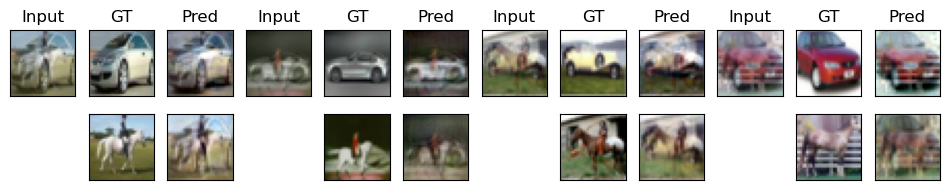

In [36]:
import matplotlib.pyplot as plt
from disentangle.analysis.plot_utils import clean_ax
imgsz = 1
nimgs = 4
idx_list = np.random.choice(range(len(x)), size=nimgs, replace=False)
_,ax = plt.subplots(figsize=(3*nimgs*imgsz,2*imgsz),ncols=3*nimgs,nrows=2)
for img_idx in range(nimgs):
    idx = idx_list[img_idx]
    print(idx)
    inp = x[idx].cpu().numpy().transpose(1,2,0)
    tar = y[idx].cpu().numpy().transpose(1,2,0)
    pred = y_pred[idx].detach().cpu().numpy().transpose(1,2,0)

    pred = (pred + 1 )/2 # [0,1]
    tar = (tar + 1 )/2 # [0,1]
    inp = (inp + 1 )/2 # [0,1]
    pred[pred<0] = 0
    pred[pred>1] = 1

    ax[0,img_idx*3 + 0].imshow(inp)
    ax[0,img_idx*3 + 1].imshow(tar[...,:3])
    ax[0,img_idx*3 + 2].imshow(pred[...,:3])
    ax[1,img_idx*3 + 1].imshow(tar[...,3:])
    ax[1,img_idx*3 + 2].imshow(pred[...,3:])
    ax[1, img_idx*3 + 0].axis('off')
    ax[0, img_idx*3 + 0].set_title('Input')
    ax[0, img_idx*3 + 1].set_title('GT')
    ax[0, img_idx*3 + 2].set_title('Pred')

clean_ax(ax)

In [20]:
pred.max()

1.1131474